In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from dateutil.parser import parse
from datetime import datetime
import math
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

from sklearn.preprocessing import MinMaxScaler
import keras_tuner
import os
import tensorflow.keras as keras
from sklearn.model_selection import GridSearchCV

**---Data Preparation---**

In [5]:
# load all the data we need in the model
oil_data = pd.read_csv('WTI crude oil futures.csv',thousands=',')
# transform the str type of data into datetime type
oil_data['Date'] = pd.to_datetime(oil_data['Date'].apply(lambda x:parse(x).strftime('%Y-%m-%d')))
oil_data = oil_data.set_index('Date').sort_index()
# transform data type
oil_data = oil_data.astype(float)
df_close = oil_data[['Close']]

In [6]:
# split training and testing set by 70% and 30%
training_size = int(len(df_close) * 0.7)
test_size = len(df_close) - training_size
train_data = df_close.iloc[0:training_size,:]
test_data = df_close.iloc[training_size:,:]

# apply MinMaxScaler to scale the time series into range of 0-1
scaler = MinMaxScaler(feature_range = (0,1))
train_data_scale = scaler.fit_transform(train_data)
train_data_scale = pd.DataFrame(train_data_scale,index = train_data.index,columns = ['Close'])
test_data_scale = scaler.transform(test_data)
test_data_scale = pd.DataFrame(test_data_scale,index = test_data.index,columns = ['Close'])

In [7]:
# create a function that transform the data to the structure for LSTM to learn
def dataset_create(data, timestep):
    data_X, data_Y = [], []
    for i in range(len(data) - timestep - 1):
        data_X.append(data.iloc[i:(i+timestep),0])
        data_Y.append(data.iloc[i+timestep,0])
    return np.array(data_X), np.array(data_Y)

In [8]:
# set a fixed time step parameter as 50
timestep = 50
X_train, Y_train = dataset_create(train_data_scale, timestep)
X_test, Y_test = dataset_create(test_data_scale, timestep)

In [9]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
X_train.shape

(1239, 50, 1)

In [60]:
def build_model(hp):
    model = keras.Sequential()
    # set the list of units to be 32~256 with step of 8
    model.add(keras.layers.LSTM(units=hp.Int('units',min_value=32,
                                        max_value=248,
                                        step=8), 
                       activation='relu', input_shape=X_train.shape[-2:]))
    model.add(keras.layers.Dense(1))
    
    # set the list of learning rate to be 3 options as below
    model.compile(loss='mae', optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
                   metrics=['mae'])
    return model

# define model
bayesian_opt_tuner = keras_tuner.BayesianOptimization(
    build_model,
    objective='mae',
    max_trials=10,
    executions_per_trial=1,
    directory=os.path.normpath('C:/Users/OliverG/Desktop/FYP/uni_var_tuner_result'),
    project_name='uni_var_WTI',
    overwrite=True)

# set epochs and batch size as fixed parameter due to lack of computing power
EPOCHS = 100
batch_size = 32
bayesian_opt_tuner.search(X_train, Y_train,
             epochs=EPOCHS,
             validation_data = (X_test,Y_test),
             validation_steps=len(X_test)//batch_size,
             steps_per_epoch=len(X_train)//batch_size,
             validation_split=0.2,verbose=1)
            

Trial 10 Complete [00h 11m 44s]
mae: 0.017183398827910423

Best mae So Far: 0.01692015677690506
Total elapsed time: 01h 31m 04s
INFO:tensorflow:Oracle triggered exit


In [1]:
import json

In [ ]:
perf_dict = {}

# load all the trial history of Bayesian Optimizer
trials = bayesian_opt_tuner.oracle.trials
for i in range(10):
    trial_id = ''
    if i < 10:
        trial_id = '0'+str(i)
    else:
        trial_id = str(i)
    directory = r'C:\Users\OliverG\Desktop\FYP\uni_var_tuner_result\uni_var_WTI\trial_'+trial_id+r'\trial.json'
    f = open(directory)
    trial_dict = json.load(f)
    perf_sum = trial_dict['hyperparameters']['values']
    print(str(perf_sum['units'])+' '+str(perf_sum['learning_rate']))
    trial_model = bayesian_opt_tuner.load_model(trials[trial_id])
    train_predict = trial_model.predict(X_train)
    test_predict = trial_model.predict(X_test)
    
    # inverse the scaled predicting result to calculate RMSE
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)

    # calculate RMSE of training and testing data
    train_RMSE = math.sqrt(mean_squared_error(scaler.inverse_transform(Y_train.reshape(-1, 1)),train_predict))
    test_RMSE = math.sqrt(mean_squared_error(scaler.inverse_transform(Y_test.reshape(-1, 1)),test_predict))
    
    # store all the results into a dictionary
    perf_dict[str(perf_sum['units'])+' '+str(perf_sum['learning_rate'])] = [train_RMSE,test_RMSE]
    f.close()
    
perf_dict

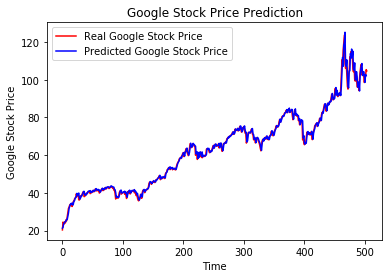

In [138]:
plt.plot(scaler.inverse_transform(test_data[timestep:]), color = 'red', label = 'Real Google Stock Price')
plt.plot(test_predict, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()